<h1><center> Pangu Weather project  <h1><center>

**[Extract of Pangu-weather github]**

"input_surface.npy stores the input surface variables. It is a numpy array shaped (4,721,1440) where the first dimension represents the 4 surface variables (MSLP, U10, V10, T2M in the exact order).

input_upper.npy stores the upper-air variables. It is a numpy array shaped (5,13,721,1440) where the first dimension represents the 5 surface variables (Z, Q, T, U and V in the exact order), and the second dimension represents the 13 pressure levels (1000hPa, 925hPa, 850hPa, 700hPa, 600hPa, 500hPa, 400hPa, 300hPa, 250hPa, 200hPa, 150hPa, 100hPa and 50hPa in the exact order).

In both cases, the dimensions of 721 and 1440 represent the size along the latitude and longitude, where the numerical range is [90,-90] degree and [0,359.75] degree, respectively, and the spacing is 0.25 degrees. For each 721x1440 slice, the data format is exactly the same as the .nc file download from the ERA5 official website.

Note that the numpy arrays should be in single precision (.astype(np.float32)), not in double precision.

We support ERA5 initial fields and ECMWF initial fields (e.g., the initial fields of the HRES forecast), where the latter often leads to a slight accuracy drop (mainly for T2M because the two fields are quite different in temperature). A .nc file of ERA5 can be transformed into a .npy file using the netCDF4 package, and a .grib file of the ECMWF initial fields can be transformed into a .npy file using the pygrib package. Note that Z represents geopotential, not geopotential height, so a factor of 9.80665 should be multiplied if the raw data contains the geopotential height.

We temporarily do not support other kinds of initial fields due to the possibly dramatic differences in the fields when Z<0.

We provide an example of transferred input files, input_surface.npy and input_upper.npy, which correspond to the ERA5 initial fields of at 12:00UTC, 2018/09/27."

# 1. Ground truth: ERA5

We will focus on the surface variables we also have access to in the Pangu Weather git demo, with units in the ERA5 dataset:
- Mean Sea Level Pressure(MSLP): Pa
- 10m u-component of wind (u10): $m.s^{-1}$
- 10m v-component of wind (v10): $m.s{-1}$
- Temperature 2m (t2m): K


In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# update your paths accordingly
path_to_netcdf_file = 'pangu_inference/era5.nc'
path_to_input_surface_file = '/Users/mayajanvier/Desktop/MVA/IA et environnement/projet/Pangu-Weather/input_data/input_surface.npy'

dataset = Dataset(path_to_netcdf_file, 'r')
dataset


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2024-03-20 23:21:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data5/adaptor.mars.internal-1710976848.021233-20718-18-044491cb-44b2-4c35-96fd-da49f6f81bdf.nc /cache/tmp/044491cb-44b2-4c35-96fd-da49f6f81bdf-adaptor.mars.internal-1710976793.392631-20718-13-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), time(96)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u10(time, latitude, longitude), int16 v10(time, latitude, longitude), int16 t2m(time, latitude, longitude), int16 z(time, latitude, longitude), int16 msl(time, latitude, longitude), int16 ust(time, latitude, longitude), int16 vst(time, latitude, longitude)
    groups: 

Our ERA dataset starts on 27/09 at 00:00 and ends on 30/09 00:00

In [3]:
# Afficher les dimensions du fichier
print("Dimensions:")
for dimname in dataset.dimensions.keys():
    dim = dataset.dimensions[dimname]
    print(f"  {dimname}: taille={len(dim)}")

# Afficher les variables disponibles dans le fichier
print("\nVariables:")
for varname in dataset.variables.keys():
    var = dataset.variables[varname]
    print(f"  {varname}: dimensions={var.dimensions}, taille={var.size}, type={var.dtype}")


Dimensions:
  longitude: taille=1440
  latitude: taille=721
  time: taille=96

Variables:
  longitude: dimensions=('longitude',), taille=1440, type=float32
  latitude: dimensions=('latitude',), taille=721, type=float32
  time: dimensions=('time',), taille=96, type=int32
  u10: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16
  v10: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16
  t2m: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16
  z: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16
  msl: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16
  ust: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16
  vst: dimensions=('time', 'latitude', 'longitude'), taille=99671040, type=int16


In [4]:
# load the variables of interest
variables = ["msl", "u10", "v10", "t2m"]
# map each variable to the indice in input_surface
map = {"msl": 0, "u10": 1, "v10": 2, "t2m": 3}


In [5]:
dataset.variables.keys()

dict_keys(['longitude', 'latitude', 'time', 'u10', 'v10', 't2m', 'z', 'msl', 'ust', 'vst'])

In [6]:
dataset.variables['msl']

<class 'netCDF4._netCDF4.Variable'>
int16 msl(time, latitude, longitude)
    scale_factor: 0.0009091316588588955
    add_offset: -0.48981918985286693
    _FillValue: -32767
    missing_value: -32767
    units: Pa
    long_name: Mean sea level pressure
    standard_name: air_pressure_at_mean_sea_level
unlimited dimensions: 
current shape = (96, 721, 1440)
filling on

In [90]:
dataset.variables['t2m']

<class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, latitude, longitude)
    scale_factor: 0.0009091316588588955
    add_offset: -0.48981918985286693
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
unlimited dimensions: 
current shape = (96, 721, 1440)
filling on

# 2. Check initial fields
We have 12 hours of shift between the two datasets (index 0 for Pangu Weather data = index 12 for ERA).

The units for the surface variables here are:
- MSLP: hPa
- u10: $m.s^{-1}$
- v10: $m.s^{-1}$
- t2m: K 

We will need a conversion for MSLP in order to compare with ERA5.

In [19]:
input_surface = np.load(path_to_input_surface_file) # input 12h
gt_surface_msl = dataset.variables['msl'][12,:,:] # ERA 12h
gt_surface_u10= dataset.variables['u10'][12,:,:]
gt_surface_v10= dataset.variables['v10'][12,:,:]
gt_surface_t2m= dataset.variables['t2m'][12,:,:]

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_init(data, var_name):
    # input from ERA
    var_idx = map[var_name]
    input_data = input_surface[var_idx]

    # numerical ranges from git 
    lats = np.linspace(-90, 90, 721) 
    lons = np.linspace(0, 359.75, 1440)

    lon_grid, lat_grid = np.meshgrid(lons, lats)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    vmax = max(input_data.max(),data.max())

    # input Pangu
    cont1 = ax[0].contourf(lon_grid, lat_grid, input_data, transform=ccrs.PlateCarree(), cmap='viridis',vmax=vmax)
    ax[0].coastlines()
    ax[0].set_title(f'{var_name} input Pangu')

    # ground truth ERA
    cont2 = ax[1].contourf(lon_grid, lat_grid, data, transform=ccrs.PlateCarree(), cmap='viridis',vmax=vmax)
    ax[1].coastlines()
    ax[1].set_title(f'{var_name} input ERA')

    # diff
    cont3 = ax[2].contourf(lon_grid, lat_grid, np.abs(input_data - data), transform=ccrs.PlateCarree(), cmap='viridis')
    ax[2].coastlines()
    ax[2].set_title(f'Difference')

    # Create colorbars
    cbar1 = fig.colorbar(cont1, ax=ax[:2], orientation='horizontal', fraction=0.05, pad=0.04, label=f'{var_name}')
    cbar2 = fig.colorbar(cont3, ax=ax[2], orientation='horizontal', fraction=0.05, pad=0.04, label='Difference')

    #plt.tight_layout()
    plt.show()


**MSL**

It seems that MSL in ERA is actually variations around some value of mean sea level pressure, as most values are in [-30,30] and the mean value of pressure at sea level being defined as 1013.25 hPa. We do not have information on how they constructed their initialisation from these variations, let's try some approaches.

In [21]:
print('ERA init MSL:',gt_surface_msl.min(), gt_surface_msl.max())
print('Pangu init MSL:',input_surface[0].min(), input_surface[0].max())

ERA init MSL: -30.278427124023438 29.299697875976562
Pangu init MSL: 94205.5 103576.5


In [22]:
# shift with standard values 
min_slp = 870 * 100 # 870 hPa, lowest possible value 
mean_slp = 1013.25 *100 # 1013.25 hPa, mean value 

# with mean 
print('Mean shift',np.abs((gt_surface_msl*100 + mean_slp -input_surface[0])).mean())
print('Min shift', np.abs((gt_surface_msl*100 + min_slp -input_surface[0])).mean())


Mean shift 1085.2279811365895
Min shift 13772.467382274797


A mean value seems more meaningful, but it is unlikely they added a single standard value to these variations to obtain `input_surface.npy` (we should get 0 error).

In [45]:
# what's the real shift we have
missing = input_surface[0] - gt_surface_msl*100 
missing.mean()
print("Mean missing shift:", np.abs((gt_surface_msl*100 + missing.mean() -input_surface[0])).mean())

Mean missing shift: 1076.2387104252687


In [50]:
missing = input_surface[0] - gt_surface_msl * 100
missing_means_lat = missing.mean(axis=1)
missing_means_lon = missing.mean(axis=0) 

corr_lat = np.zeros_like(gt_surface_msl)
corr_lon = np.zeros_like(gt_surface_msl)

# add mean over latitude
for i in range(gt_surface_msl.shape[1]):
    corr_lat[:,i] = gt_surface_msl[:,i]*100 + missing_means_lat

# add mean over longitude
for i in range(gt_surface_msl.shape[0]):
    corr_lon[i,:] = gt_surface_msl[i,:]*100 + missing_means_lon

print("Mean lon missing shift:", np.abs((corr_lon - input_surface[0])).mean())
print("Mean lat missing shift:", np.abs((corr_lat - input_surface[0])).mean())

Mean lon missing shift: 1068.4290301909427
Mean lat missing shift: 696.3951024413782


The best guess is for now some latitudinal mean of the sea level pressure.

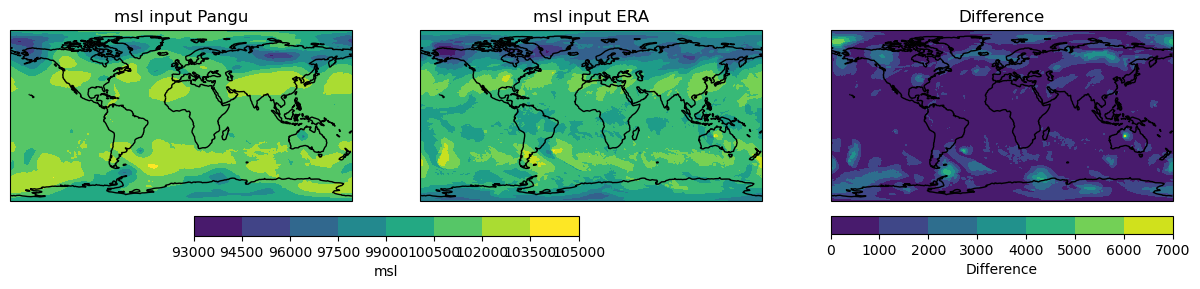

In [111]:
plot_init(corr_lat,'msl')

**U10**

In [74]:
np.abs((gt_surface_u10 -input_surface[map['u10']])).mean() # u10

6.179857748403948

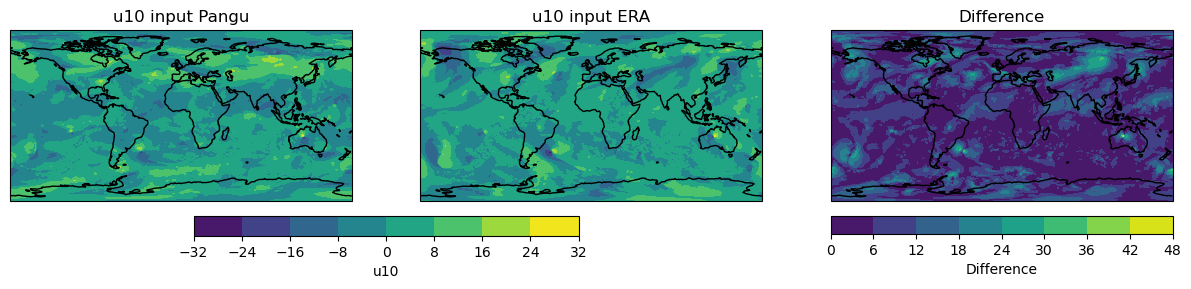

In [112]:
plot_init(gt_surface_u10,'u10')

**V10**

In [75]:
np.abs((gt_surface_v10 -input_surface[map['v10']])).mean() # v10

2.657488855141501

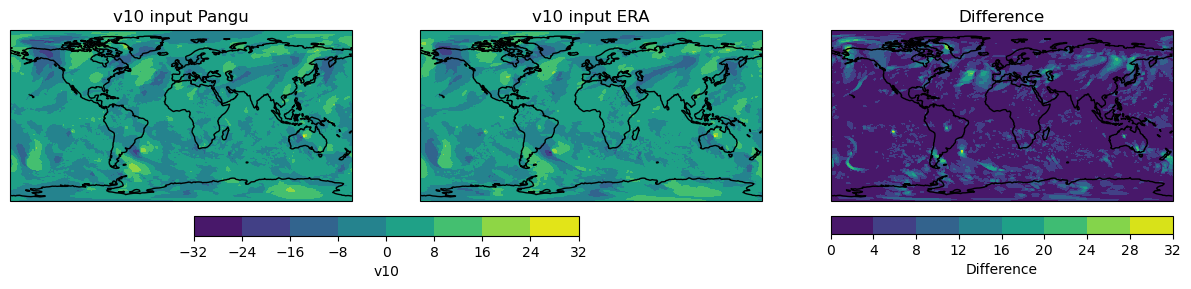

In [76]:
plot_init(gt_surface_v10,'v10')

**T2M**

We observe a really weird thing: in our ERA5 substract, the msl and t2m variables are entirely equal.
As we recover an acceptable approximation of the input when adding to t2m the zero degree in kelvin (273.15), we suppose that t2m/msl can be interpreted as t2m variations around zero.  

In [110]:
# perfect equality between msl and t2m from ERA for our subset
(dataset.variables['msl'][:,:,:] == dataset.variables['t2m'][:,:,:]).min()

True

In [5]:
zero_kelvin = 273.15

In [113]:
print('Input Pangu',input_surface[map['t2m']].min(),input_surface[map['t2m']].max())
print('Input ERA', gt_surface_t2m.min()+zero_kelvin, gt_surface_t2m.max()+zero_kelvin)

Input Pangu 207.04808 317.43286
Input ERA 242.87157287597654 302.44969787597654


In [106]:
np.abs((gt_surface_t2m + zero_kelvin - input_surface[map['t2m']])).mean() # t2m

19.02929078788696

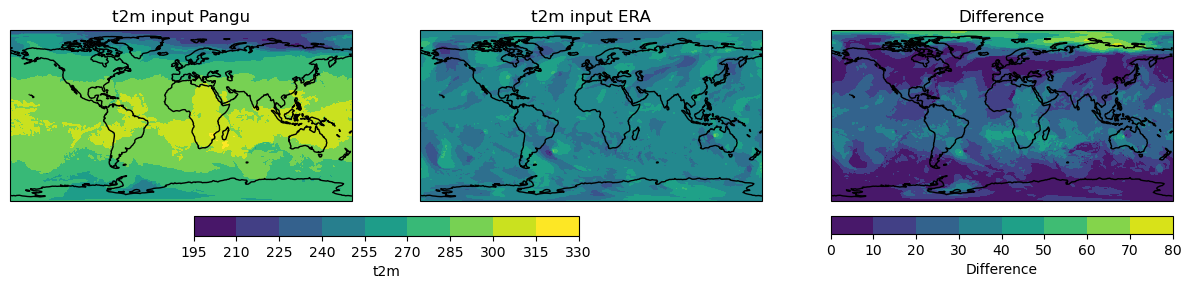

In [107]:
plot_init(gt_surface_t2m + zero_kelvin,'t2m')

# 3. Predicted forecasts with Pangu Weather
Since we are unsure of the definition of MSLP within ERA5, we will only look at u10, v10 and t2m forecasts. We want to compare the quality of the different lead times:
- 1 hour
- 3 hours
- 6 hours
- 24 hours


In [7]:
def load_numpy(prefix, step, output_data_dir):
    path_upper = os.path.join(output_data_dir, f'{prefix}_{step}.npy')
    path_surface = os.path.join(output_data_dir, f'{prefix}_surface_{step}.npy')
    upper = np.load(path_upper)
    surface = np.load(path_surface)
    return upper.astype(np.float32), surface.astype(np.float32) # ensure type 
    
def compute_RMSE(predicted, ground_truth):
    return np.sqrt(np.mean((predicted - ground_truth)**2))

def compute_MAE(predicted, ground_truth):
    return np.mean(np.abs(predicted - ground_truth))

In [8]:
# update path accordingly
output_data_dir = 'pangu_inference/output_data_24'

# compare 6 hours lead time 
_, surface_1_6 = load_numpy("output_1", 6, output_data_dir)
_, surface_3_6 = load_numpy("output_3", 6, output_data_dir)
_, surface_6_6 = load_numpy("output_6", 6, output_data_dir)

# compare 24 hours lead time
_, surface_1_24 = load_numpy("output_1", 24, output_data_dir)
_, surface_3_24 = load_numpy("output_3", 24, output_data_dir)
_, surface_6_24 = load_numpy("output_6", 24, output_data_dir)
_, surface_24_24 = load_numpy("output_24", 24, output_data_dir)

In [11]:
# visualisation on world map
def plot_surface_6h(data = dataset, variable = "t2m"):
    gt = data.variables[variable][12+6, :, :] # start + 6
    variable_idx = map[variable]

    # numerical ranges from git 
    lats = np.linspace(-90, 90, 721) 
    lons = np.linspace(0, 359.75, 1440)

    lon_grid, lat_grid = np.meshgrid(lons, lats)

    fig, axs = plt.subplots(1, 4, figsize=(15, 30), subplot_kw={'projection': ccrs.PlateCarree()})

    surfaces_variable = [surface_1_6[variable_idx], surface_3_6[variable_idx], surface_6_6[variable_idx], gt]
    vmax = np.array([surface.max() for surface in surfaces_variable]).max() # for shared color bar 
    titles = [f'Lead time 1 hour {variable}', f'Lead time 3 hour {variable}', f'Lead time 6 hour {variable}', f'Ground truth {variable}']
    i = 0

    for surface in surfaces_variable:
        title = titles[i]
        ax = axs[i]
        if variable == "t2m":
            if i==3: # era t2m truth +273.15
                surface = surface + 273.15 # in C
        cont = ax.contourf(lon_grid, lat_grid, surface, transform=ccrs.PlateCarree(), cmap='viridis', vmax=vmax)
        ax.coastlines()
        ax.set_title(title)
        i+=1

    fig.colorbar(cont, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04, label=f'{variable}')
    plt.tight_layout()

    plt.show()



/var/folders/hd/6gcp429169ldrntwtps0b1_m0000gp/T/ipykernel_29764/933780090.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


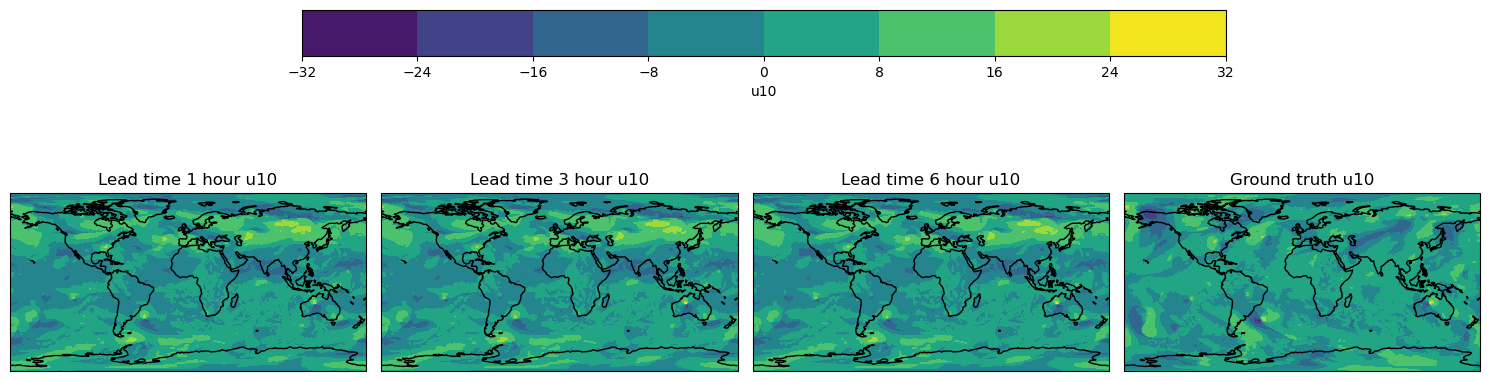

/var/folders/hd/6gcp429169ldrntwtps0b1_m0000gp/T/ipykernel_29764/933780090.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


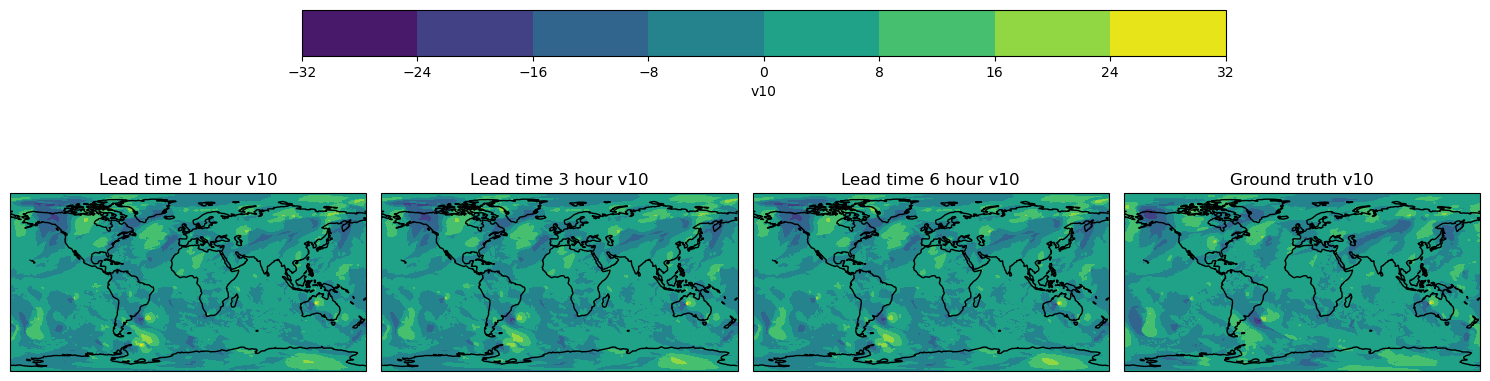

/var/folders/hd/6gcp429169ldrntwtps0b1_m0000gp/T/ipykernel_29764/933780090.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


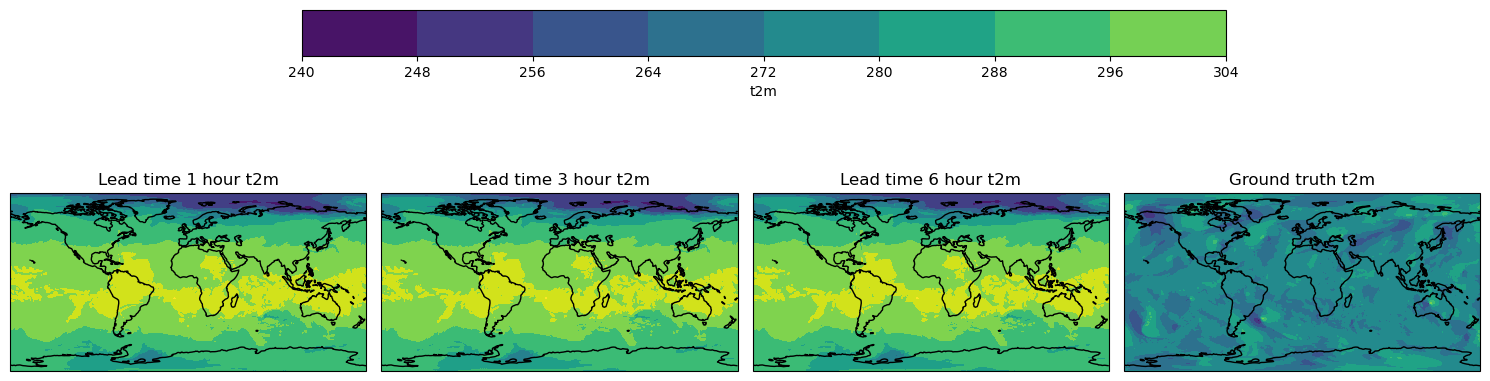

In [12]:
for variable in variables[1:]: # no msl 
    plot_surface_6h(data = dataset, variable = variable)

In [ ]:
# visualisation on world map
def plot_surface_24h(data = dataset, variable = "t2m"):
    gt = data.variables[variable][12+24, :, :] # start + 24
    variable_idx = map[variable]

    # numerical ranges from git 
    lats = np.linspace(-90, 90, 721) 
    lons = np.linspace(0, 359.75, 1440)

    lon_grid, lat_grid = np.meshgrid(lons, lats)

    fig, axs = plt.subplots(1, 4, figsize=(15, 30), subplot_kw={'projection': ccrs.PlateCarree()})

    surfaces_variable = [surface_1_24[variable_idx], surface_3_24[variable_idx], surface_6_24[variable_idx], surface_24_24[variable_idx], gt]
    titles = [f'Lead time 1 hour {variable}', f'Lead time 3 hour {variable}', f'Lead time 6 hour {variable}',
              f'Lead time 24 hour {variable}', f'Ground truth {variable}']
    i = 0

    for surface in surfaces_variable:
        title = titles[i]
        ax = axs[i]
        if variable == "t2m":
            if i == 4: # t2m era + 273.15
                surface = surface + 273.15 # in C
        cont = ax.contourf(lon_grid, lat_grid, surface, transform=ccrs.PlateCarree(), cmap='viridis')
        ax.coastlines()
        ax.set_title(title)
        i+=1

    fig.colorbar(cont, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04, label=f'{variable}')
    plt.tight_layout()

    plt.show()



In [ ]:
for variable in variables[1:]: # no msl 
    plot_surface_24h(data = dataset, variable = variable)

# 4. RMSE curves 

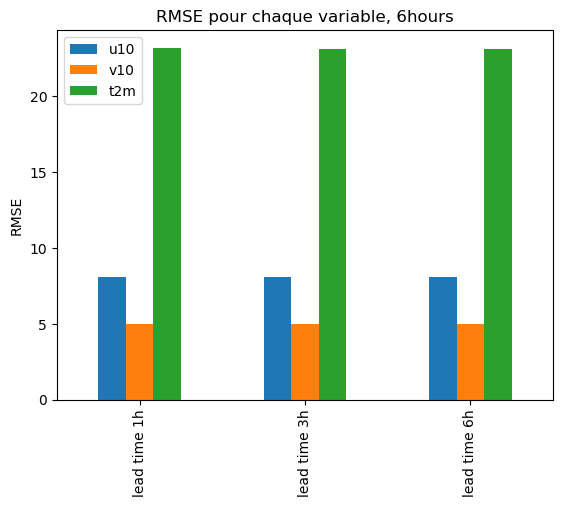

In [27]:
def get_RMSE_for_variable_6h(data = dataset , variable = "t2m"):
    gt = data.variables[variable][12+6, :, : ]
    variable_idx = map[variable]
    surfaces_variable = [surface_1_6[variable_idx], surface_3_6[variable_idx], surface_6_6[variable_idx]]
    RMSE_list = []
    for surface in surfaces_variable:
        if variable=='t2m':
            RMSE_list.append(compute_RMSE(surface, gt+273.15))
        elif variable=='msl':
            RMSE_list.append(compute_RMSE(surface, gt*100+mean_slp))
        else:
            RMSE_list.append(compute_RMSE(surface, gt))

    return RMSE_list

RMSE6 = {}
for variable in variables:
    RMSE6[variable] = get_RMSE_for_variable_6h(dataset, variable)

# remove msl
del RMSE6["msl"]

RMSE_df = pd.DataFrame(RMSE6, index=['lead time 1h', 'lead time 3h', 'lead time 6h'])
RMSE_df.plot(kind='bar', title='RMSE pour chaque variable, 6hours', ylabel='RMSE')
plt.show()

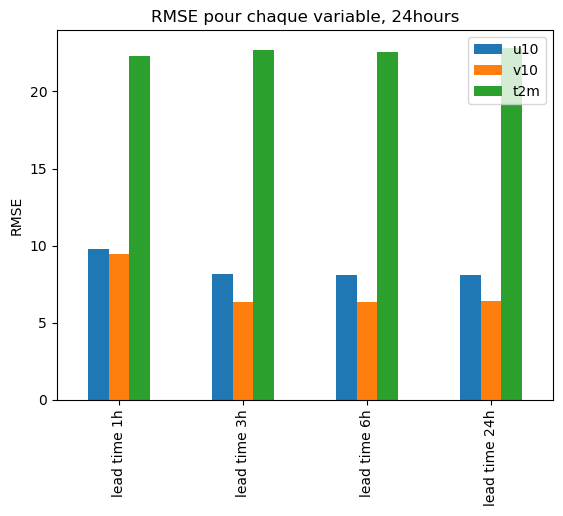

In [44]:
def get_RMSE_for_variable_24h(data = dataset , variable = "t2m"):
    gt = data.variables[variable][12+24, :, : ]
    variable_idx = map[variable]
    surfaces_variable = [surface_1_24[variable_idx], surface_3_24[variable_idx], surface_6_24[variable_idx], surface_24_24[variable_idx]]
    RMSE_list = []
    for surface in surfaces_variable:
        if variable=='t2m':
            RMSE_list.append(compute_RMSE(surface, gt+273.15))
        elif variable=='msl':
            RMSE_list.append(compute_RMSE(surface, gt*100+mean_slp))
        else:
            RMSE_list.append(compute_RMSE(surface, gt))

    return RMSE_list

RMSE24 = {}
for variable in variables:
    RMSE24[variable] = get_RMSE_for_variable_24h(dataset, variable)

# remove msl
del RMSE24["msl"]

RMSE_df = pd.DataFrame(RMSE24, index=['lead time 1h', 'lead time 3h', 'lead time 6h', 'lead time 24h'])
RMSE_df.plot(kind='bar', title='RMSE pour chaque variable, 24hours', ylabel='RMSE')
plt.show()

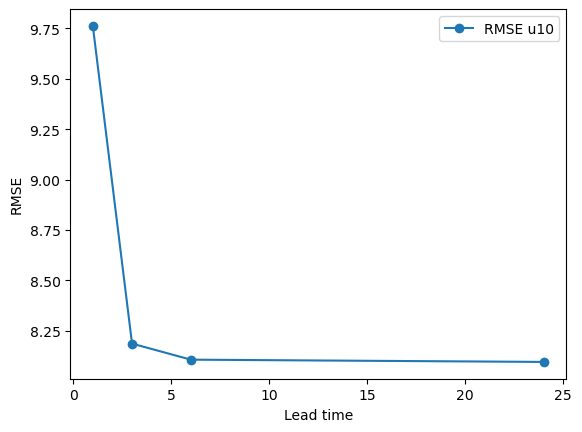

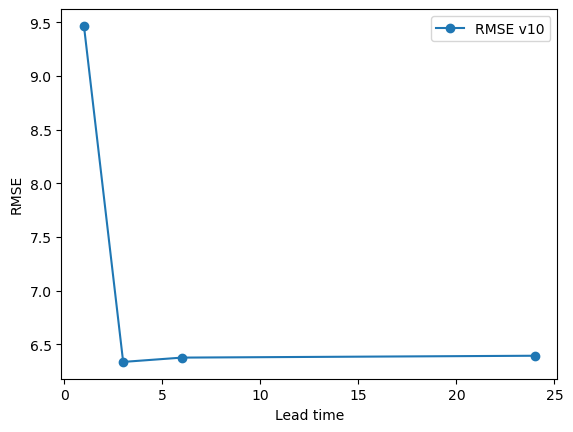

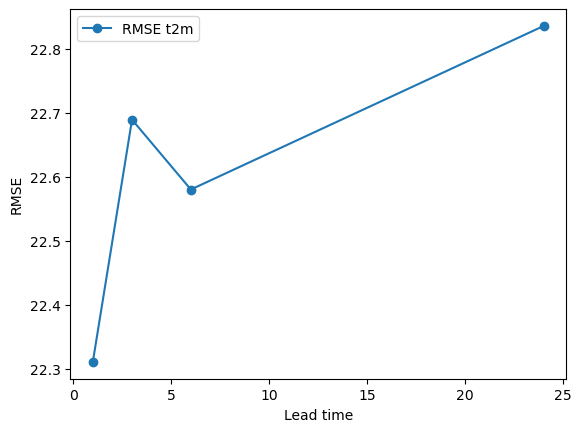

In [45]:
lead_times = [1,3,6,24]
for var in RMSE24.keys():
    plt.figure()
    plt.plot(lead_times,RMSE24[var],'o-',label=f'RMSE {var}')
    plt.xlabel('Lead time')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show


# 5. RMSE 24H forecasting

In [51]:
output_data_dir = "pangu_inference/output_data_24"

# t2m from era for 24h
gt_t2m = [dataset.variables['t2m'][12+i, :, :] for i in range(24)]
gt_t2m = np.array(gt_t2m) + zero_kelvin

# gt_u10 from era for 24h
gt_u10 = [dataset.variables['u10'][12+i, :, :] for i in range(24)]
gt_u10 = np.array(gt_u10)

# gt_v10 from era for 24h
gt_v10 = [dataset.variables['v10'][12+i, :, :] for i in range(24)]
gt_v10 = np.array(gt_v10)

# hours range
forecast_hours_lead_time_1 = np.array(np.arange(1, 25))
forecast_hours_lead_time_3 = np.array(np.arange(3, 25, 3))
forecast_hours_lead_time_6 = np.array(np.arange(6, 25, 6))
forecast_hours_lead_time_24 = np.array(np.arange(14, 25, 24))

# t2m predicted
surface_1_t2m = [load_numpy("output_1", i, output_data_dir)[1][map["t2m"]] for i in range(1,25)]
surface_3_t2m = [load_numpy("output_3", i, output_data_dir)[1][map["t2m"]] for i in range(3,25,3)]
surface_6_t2m = [load_numpy("output_6", i, output_data_dir)[1][map["t2m"]] for i in range(6,25,6)]
surface_24_t2m = [load_numpy("output_24", i, output_data_dir)[1][map["t2m"]] for i in range(24, 25, 24)]

## u10 predicted
surface_1_u10 = [load_numpy("output_1", i, output_data_dir)[1][map["u10"]] for i in range(1, 25)]
surface_3_u10 = [load_numpy("output_3", i, output_data_dir)[1][map["u10"]] for i in range(3, 25, 3)]
surface_6_u10 = [load_numpy("output_6", i, output_data_dir)[1][map["u10"]] for i in range(6, 25, 6)]
surface_24_u10 = [load_numpy("output_24", i, output_data_dir)[1][map["u10"]] for i in range(24, 25, 24)]

## u10 predicted
surface_1_v10 = [load_numpy("output_1", i, output_data_dir)[1][map["v10"]] for i in range(1, 25)]
surface_3_v10 = [load_numpy("output_3", i, output_data_dir)[1][map["v10"]] for i in range(3, 25, 3)]
surface_6_v10 = [load_numpy("output_6", i, output_data_dir)[1][map["v10"]] for i in range(6, 25, 6)]
surface_24_v10 = [load_numpy("output_24", i, output_data_dir)[1][map["v10"]] for i in range(24, 25, 24)]



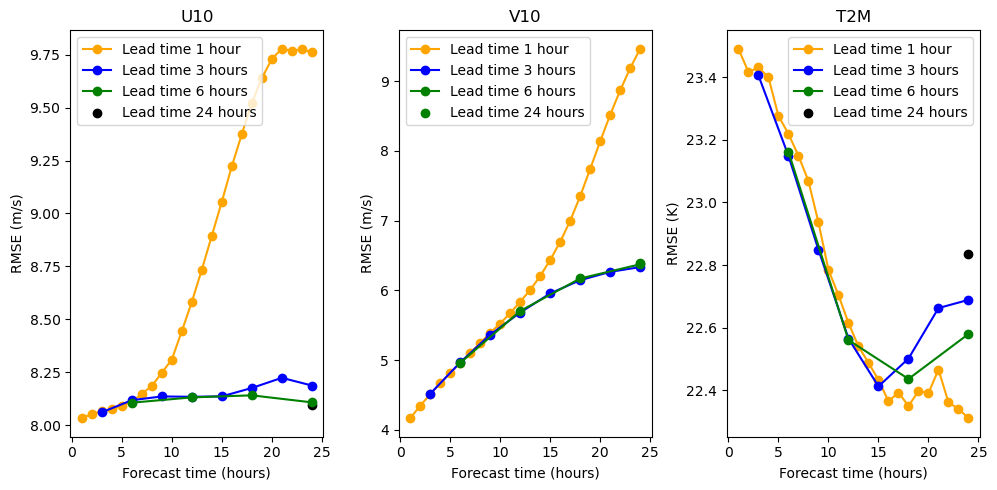

In [61]:
# compute rmse 

# Pseudo-code pour calculer RMSE pour chaque lead time pour 't2m'
# Les lignes de calcul spécifiques pour RMSE_t2m_lead_time_* seraient quelque chose comme :
RMSE_t2m_lead_time_1 = [compute_RMSE(gt_t2m[i], surface_1_t2m[i]) for i in range(len(surface_1_t2m))]
RMSE_t2m_lead_time_3 = [compute_RMSE(gt_t2m[3*i], surface_3_t2m[i]) for i in range(len(surface_3_t2m))]
RMSE_t2m_lead_time_6 = [compute_RMSE(gt_t2m[6*i], surface_6_t2m[i]) for i in range(len(surface_6_t2m))]
RMSE_t2m_lead_time_24 = [compute_RMSE(gt_t2m[24*i], surface_24_t2m[i]) for i in range(len(surface_24_t2m))]


RMSE_u10_lead_time_1 = [compute_RMSE(gt_u10[i], surface_1_u10[i]) for i in range(len(surface_1_u10))]
RMSE_u10_lead_time_3 = [compute_RMSE(gt_u10[3*i], surface_3_u10[i]) for i in range(len(surface_3_u10))]
RMSE_u10_lead_time_6 = [compute_RMSE(gt_u10[6*i], surface_6_u10[i]) for i in range(len(surface_6_u10))]
RMSE_u10_lead_time_24 = [compute_RMSE(gt_u10[24*i], surface_24_u10[i]) for i in range(len(surface_24_u10))]


RMSE_v10_lead_time_1 = [compute_RMSE(gt_v10[i], surface_1_v10[i]) for i in range(len(surface_1_v10))]
RMSE_v10_lead_time_3 = [compute_RMSE(gt_v10[3*i], surface_3_v10[i]) for i in range(len(surface_3_v10))]
RMSE_v10_lead_time_6 = [compute_RMSE(gt_v10[6*i], surface_6_v10[i]) for i in range(len(surface_6_v10))]
RMSE_v10_lead_time_24 = [compute_RMSE(gt_v10[24*i], surface_24_v10[i]) for i in range(len(surface_24_v10))]


# Création du graphique
fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # Ajuster la taille si nécessaire

# Tracé pour U10
axs[0].plot(forecast_hours_lead_time_1, RMSE_u10_lead_time_1, 'o-', label='Lead time 1 hour', color='orange')
axs[0].plot(forecast_hours_lead_time_3, RMSE_u10_lead_time_3, 'o-', label='Lead time 3 hours', color='blue')
axs[0].plot(forecast_hours_lead_time_6, RMSE_u10_lead_time_6, 'o-', label='Lead time 6 hours', color='green')
axs[0].scatter(24.0, RMSE_u10_lead_time_24[0], label='Lead time 24 hours', color='black')

axs[0].set_title('U10')
axs[0].set_xlabel('Forecast time (hours)')
axs[0].set_ylabel('RMSE (m/s)')
axs[0].legend()


# Tracé pour V10
axs[1].plot(forecast_hours_lead_time_1, RMSE_v10_lead_time_1, 'o-', label='Lead time 1 hour', color='orange')
axs[1].plot(forecast_hours_lead_time_3, RMSE_v10_lead_time_3, 'o-', label='Lead time 3 hours', color='blue')
axs[1].plot(forecast_hours_lead_time_6, RMSE_v10_lead_time_6, 'o-', label='Lead time 6 hours', color='green')
axs[1].scatter(24.0, RMSE_v10_lead_time_24[0],label='Lead time 24 hours', color='green')

axs[1].set_title('V10')
axs[1].set_xlabel('Forecast time (hours)')
axs[1].set_ylabel('RMSE (m/s)')
axs[1].legend()

# Tracé pour T2M
axs[2].plot(forecast_hours_lead_time_1, RMSE_t2m_lead_time_1, 'o-', label='Lead time 1 hour', color='orange')
axs[2].plot(forecast_hours_lead_time_3, RMSE_t2m_lead_time_3, 'o-', label='Lead time 3 hours', color='blue')
axs[2].plot(forecast_hours_lead_time_6, RMSE_t2m_lead_time_6, 'o-', label='Lead time 6 hours', color='green')
axs[2].scatter(24.0, RMSE_t2m_lead_time_24[0], label='Lead time 24 hours', color='black')


axs[2].set_title('T2M')
axs[2].set_xlabel('Forecast time (hours)')
axs[2].set_ylabel('RMSE (K)')
axs[2].legend()



# Affichage du graphique
plt.tight_layout()  # Ajuster l'espacement
plt.show()
